# Analysis of SEIRX model runs for test technology and screening frequency

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import analysis_functions as af

In [214]:
language = 'english'

## Mappings of variables to plot labels

In [215]:
# English
if language == 'english':
    frequency_name_map = {np.nan:'never',
              2:'3 times\na week',
              3:'twice\na week',
              7:'once\na week'}

    test_name_map = {
        'same_day_antigen':'same-day antigen',
        'one_day_PCR':'one day PCR',
        'two_day_PCR':'two days PCR',
        'same_day_PCR':'same-day PCR',
        'same_day_LAMP':'same-day RT-LAMP'}

    metric_name_map = {
        'infected_residents_mean':'follow-up cases residents (mean)',
        'infected_residents_median':'follow-up cases residends (median)',
        'infected_residents_0.90':'follow-up cases residents (90th percentile)',
        'R0_mean':'$R_0$',
        'R0_mean':'$R_0$',
        'infected_residents':'follow-up cases residents'}

    index_case_map = {'employee':'index case employee',
                      'resident':'index case resident'}
    
    xlabel = 'screening frequency employees'
    ylabel = 'screening freuqency residents'
    
    screening_intervals = ['never', 'once\na week', 'twice\na week', 
                           '3 times\na week']

# German
if language == 'german':
    frequency_name_map = {np.nan:'nie',
                  2:'3 mal\npro Woche',
                  3:'2 mal\npro Woche',
                  7:'ein mal\npro Woche'}

    test_name_map = {
        'same_day_antigen':'Antigen (selber Tag)',
        'one_day_PCR':'PCR (1 Tag)',
        'two_day_PCR':'PCR (2 Tage)',
        'same_day_PCR':'PCR (selber Tag)', 
        'same_day_LAMP':'RT-LAMP (selber Tag)'}

    metric_name_map = {
        'infected_residents_mean':'Folgefälle BewohnerInnen (Mittelwert)',
        'infected_residents_median':'Folgefälle BewohnerInnen (Median)',
        'infected_residents_0.90':'Folgefälle BewohnerInnen (90. Percentile)',
        'R0_mean':'$R_0$',
        'R0_mean':'$R_0$',
        'infected_residents':'Folgefälle BewohnerInnen'}

    index_case_map = {'employee':'Indexfall MitarbeiterIn',
                      'resident':'Indexfall BewohnerIn'}
    
    xlabel = 'Testfrequenz MitarbeiterInnen'
    ylabel = 'Testfrequenz BewohnerInnen'
    
    screening_intervals = ['nie', 'ein mal\npro Woche', '2 mal\npro Woche',
                           '3 mal\npro Woche']

## Helper functions

## Analysis wild type

### Data loading and wrangling

In [217]:
res_path = '../data/simulation_results'
dst_path = '../plots/'
sim_name = 'simulations_testing_strategy'
N_runs = 5000
data = pd.read_csv(join(res_path,'{}_{}.csv'.format(sim_name, N_runs)))

In [218]:
# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

# set screen intervals, test types and index case as categorical variables with
# explicit order, to facilitate sorting in a nicer way
data['resident_screen_interval'] = pd.Categorical(data['resident_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['employee_screen_interval'] = pd.Categorical(data['employee_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['test_type'] = pd.Categorical(data['test_type'], 
    categories=['same_day_antigen', 'same_day_LAMP', 'same_day_PCR', 'one_day_PCR',  
                'two_day_PCR',], ordered=True)

data['index_case'] = pd.Categorical(data['index_case'], 
    categories=['employee', 'resident'], ordered=True)

data = data.sort_values(by=['test_type', 'employee_screen_interval', 
                            'resident_screen_interval', 'index_case'],
                       ascending=True)

data = data.set_index(['test_type', 'employee_screen_interval', 
                       'resident_screen_interval', 'index_case'])

### Different test technologies

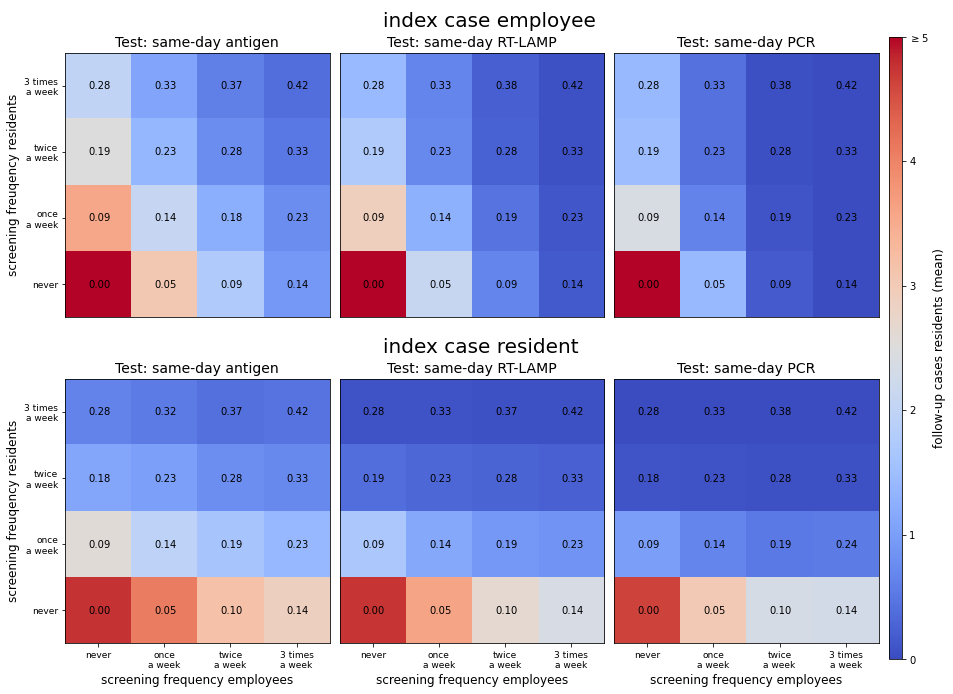

In [219]:
metric = 'infected_residents_mean'
sim_name = 'simulation_results'
screening_params = screening_intervals

# figure layout & axis setup
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(nrows=4, ncols=4, width_ratios=[1,1,1, 0.05],\
                       height_ratios=[0.1,1,0.1,1], wspace=0.05, hspace=0)

title_ax_1 = fig.add_subplot(gs[0, 0:])
hmap_ax_1 = fig.add_subplot(gs[1, 0])
hmap_ax_2 = fig.add_subplot(gs[1, 1])
hmap_ax_3 = fig.add_subplot(gs[1, 2])

title_ax_2 = fig.add_subplot(gs[2, 0:])
hmap_ax_4 = fig.add_subplot(gs[3, 0])
hmap_ax_5 = fig.add_subplot(gs[3, 1])
hmap_ax_6 = fig.add_subplot(gs[3, 2])

cbar_ax = fig.add_subplot(gs[1:, 3])

hmap_axes = [[hmap_ax_1, hmap_ax_2, hmap_ax_3], [hmap_ax_4, hmap_ax_5, hmap_ax_6]]
title_axes = [title_ax_1, title_ax_2]

# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin=0
vmax=5
vstep=1

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode in enumerate(['employee', 'resident']):
    df = data.loc[:,:,:, index_case_mode]
    
    # remove all axis labels and ticks for the heatmaps
    t_ax = title_axes[i]
    t_ax.set_xticks([])
    t_ax.set_yticks([])
    t_ax.set_frame_on(False)
    t_ax.set_xlim(0, 1)
    t_ax.set_ylim(0, 3)
    t_ax.text(0.38, 1, index_case_map[index_case_mode], fontsize=20)
        
    j = 0
    # compare same-day turnover testing for different testing technologies
    for j, ax, test_type in zip(range(3), hmap_axes[i],\
                       ['same_day_antigen', 'same_day_LAMP', 'same_day_PCR']):
        
        # set flag to set axis ticks only for heatmaps at the boundaries of 
        # the figure
        xticks = False
        yticks = False
        if i > 0:
            xticks = True
        if j in [0, 3]:
            yticks = True
            
        # put the testing technology in the heatmap title
        ax.set_title('Test: {}'\
                .format(test_name_map[test_type]), fontsize=14)
        
        # plot heatmap of the scenario
        img = af.get_image(df, test_type, screening_params, metric)
        if index_case_mode == 'resident':
            # if a resident is the index case, we need to subtract 1 from the
            # number of infected residents, to calculate the "outbreak size",
            # which is defined as the number of FOLLOW-UP cases, given an index
            # case
            img = img - 1
        img_plot = af.plot_heatmap(ax, img, screening_params, vmin, vmax,
                                   xticks, yticks, xlabel, ylabel)
        
        # annotate heatmap with tests / days / agent
        test_rate = af.get_image(df, test_type, screening_params, 
                                    'test_rate_mean')
        af.annotate_heatmap(ax, test_rate)
        
# colorbar
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                        ticks=np.arange(vmin, vmax + 1, vstep))
yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)      

plt.savefig(join(dst_path, 'screening_frequency_test_technology_{}.png'\
                .format(language[0:3])), dpi=300, transparent=True)
plt.savefig(join(dst_path, 'screening_frequency_test_technology_{}.pdf'\
                .format(language[0:3])), transparent=True)

### PCR: different turnover times

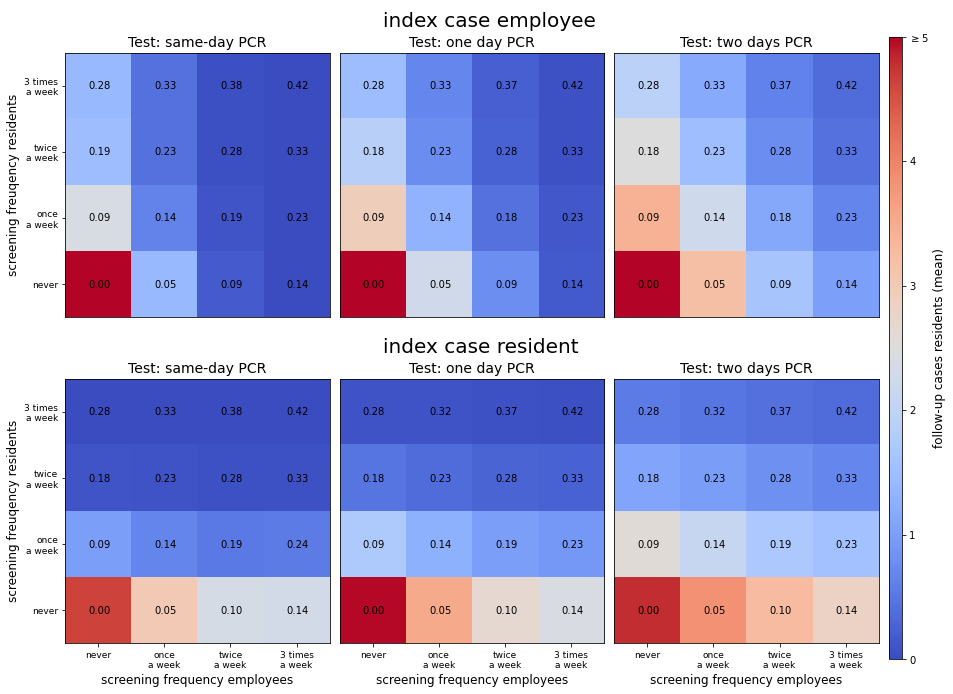

In [220]:
metric = 'infected_residents_mean'
sim_name = 'simulation_results'
screening_params = screening_intervals

# figure layout & axis setup
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(nrows=4, ncols=4, width_ratios=[1,1,1, 0.05],\
                       height_ratios=[0.1,1,0.1,1], wspace=0.05, hspace=0)

title_ax_1 = fig.add_subplot(gs[0, 0:])
hmap_ax_1 = fig.add_subplot(gs[1, 0])
hmap_ax_2 = fig.add_subplot(gs[1, 1])
hmap_ax_3 = fig.add_subplot(gs[1, 2])

title_ax_2 = fig.add_subplot(gs[2, 0:])
hmap_ax_4 = fig.add_subplot(gs[3, 0])
hmap_ax_5 = fig.add_subplot(gs[3, 1])
hmap_ax_6 = fig.add_subplot(gs[3, 2])

cbar_ax = fig.add_subplot(gs[1:, 3])

hmap_axes = [[hmap_ax_1, hmap_ax_2, hmap_ax_3], [hmap_ax_4, hmap_ax_5, hmap_ax_6]]
title_axes = [title_ax_1, title_ax_2]

# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 5
vstep = 1

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode in enumerate(['employee', 'resident']):
    df = data.loc[:,:,:, index_case_mode]
    
    # set flag to set axis ticks only for heatmaps at the boundaries of 
    # the figure
    t_ax = title_axes[i]
    t_ax.set_xticks([])
    t_ax.set_yticks([])
    t_ax.set_frame_on(False)
    t_ax.set_xlim(0, 1)
    t_ax.set_ylim(0, 3)
    t_ax.text(0.38, 1, index_case_map[index_case_mode], fontsize=20)
    
    # compare different test result turnover times for PCR tests
    for j, ax, test_type in zip(range(3), hmap_axes[i], \
                        ['same_day_PCR', 'one_day_PCR', 'two_day_PCR']):
        xticks = False
        yticks = False
        if i > 0:
            xticks = True
        if j in [0, 3]:
            yticks = True
            
        # put the turnover time in the heatmap title
        ax.set_title('Test: {}'\
                .format(test_name_map[test_type]), fontsize=14)
        
        # plot heatmap of the scenario
        img = af.get_image(df, test_type, screening_params, metric)
        if index_case_mode == 'resident':
            img = img - 1
        img_plot = af.plot_heatmap(ax, img, screening_params, vmin, vmax,
                                   xticks, yticks, xlabel, ylabel)
        
        # annotate heatmap with tests / days / agent
        test_rate = af.get_image(df, test_type, screening_params, 
                                    'test_rate_mean')
        af.annotate_heatmap(ax, test_rate)

# colorbar
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                ticks=np.arange(vmin, vmax+1, vstep))
yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)      

plt.savefig(join(dst_path, 'screening_frequency_PCR_turnover_time_{}.png'\
                .format(language[0:3])), dpi=300, transparent=True)
plt.savefig(join(dst_path, 'screening_frequency_PCR_turnover_time_{}.pdf'\
                .format(language[0:3])))

### Number of agents infected by the index case

In [221]:
# all ensembles that had no preventive testing in place (the test technology
# does not make a difference, because it is only used for potential preventive
# tests anyways)
no_measures = data.loc[:,'never', 'never'].copy().reset_index()
nm_residents = no_measures[no_measures['index_case'] == 'resident']
nm_employees = no_measures[no_measures['index_case'] == 'employee']

In [222]:
print('index case resident: R = {:1.4f} +- {:1.4f}'\
      .format(nm_residents['R0_mean'].mean(), nm_residents['R0_std'].mean()))
print('index case employee: R = {:1.4f} +- {:1.4f}'\
      .format(nm_employees['R0_mean'].mean(), nm_employees['R0_std'].mean()))

index case resident: R = 1.3539 +- 1.5030
index case employee: R = 1.2921 +- 1.4382


### Outbreak sizes

**Note**: for resident index cases, the index case needs to be subtracted from the outbreak size

#### Only TTI

In [223]:
nm_residents['infected_residents_mean'] - 1

1    4.7478
3    4.7438
5    4.6290
7    4.9614
9    4.8004
Name: infected_residents_mean, dtype: float64

In [224]:
nm_residents['infected_residents_std'] - 1

1    5.716012
3    5.725058
5    5.584590
7    5.854087
9    5.631422
Name: infected_residents_std, dtype: float64

In [225]:
nm_employees['infected_residents_mean']

0    5.2882
2    5.1344
4    5.0508
6    5.1332
8    5.0852
Name: infected_residents_mean, dtype: float64

In [226]:
nm_employees['infected_residents_std']

0    7.123461
2    7.062260
4    6.870579
6    7.032307
8    7.011489
Name: infected_residents_std, dtype: float64

#### Minimum and maximum

In [227]:
data['infected_residents_mean'].idxmin()

('same_day_PCR', '3 times\na week', '3 times\na week', 'employee')

In [228]:
data.loc[data['infected_residents_mean'].idxmin()]['infected_residents_mean']

0.0

In [229]:
data.loc[data['infected_residents_mean'].idxmin()]['infected_residents_std']

0.0

#### Realistic scenario I: employees screened 2x / week

##### Same-day Antigen

In [230]:
# employee index case
mean = data.loc['same_day_antigen', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_antigen', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.7722 +- 3.969465769054866


In [231]:
# resident index case
mean = data.loc['same_day_antigen', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.1654 +- 4.789470810656353


##### Same-day LAMP

In [232]:
# employee index case
mean = data.loc['same_day_LAMP', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_LAMP', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.6674 +- 2.323931447240709


In [233]:
# resident index case
mean = data.loc['same_day_LAMP', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_LAMP', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.6388 +- 4.112434435148684


##### One-day PCR

In [234]:
# employee index case
mean = data.loc['one_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['one_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.7964 +- 2.6202137592243893


In [235]:
# resident index case
mean = data.loc['one_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['one_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.6718 +- 4.219673670934499


##### Same-day PCR

In [236]:
# employee index case
mean = data.loc['same_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.1782 +- 1.2336730319780709


In [237]:
# resident index case
mean = data.loc['same_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.3536 +- 3.781828590179241


##### Two-day PCR

In [238]:
# employee index case
mean = data.loc['two_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.63 +- 3.813555905153135


In [239]:
# resident index case
mean = data.loc['two_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.2748 +- 4.907474057019972


#### Realistic scenario II: employees screened 1x / week

##### Same-day PCR

In [240]:
# employee index case
mean = data.loc['same_day_PCR', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.4098 +- 3.5648850810549595


In [241]:
# resident index case
mean = data.loc['same_day_PCR', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.0271999999999997 +- 4.606550143094522


##### Same-day LAMP

In [242]:
# employee index case
mean = data.loc['same_day_LAMP', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_LAMP', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.1286 +- 4.516120138816244


In [243]:
# resident index case
mean = data.loc['same_day_LAMP', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_LAMP', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.6026 +- 5.305836750289642


##### Same-day Antigen

In [244]:
# employee index case
mean = data.loc['same_day_antigen', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_antigen', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.042 +- 5.435121351802714


In [245]:
# resident index case
mean = data.loc['same_day_antigen', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

4.0696 +- 5.786454220892972


#### Two-day PCR

##### Employees 3x / week, residents never 

In [246]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.0166 +- 2.949790618491181


In [247]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.824 +- 4.36605502568365


##### Employees 3x / week, residents 1x / week 

In [248]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.6734 +- 2.011552064536652


In [249]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.5779999999999998 +- 2.72884688486991


##### Employees 3x / week, residents 2x / week 

In [250]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.4414 +- 1.2504714214068031


In [251]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.6946000000000001 +- 1.5008602054392854


##### Employees 3x / week, residents 3x / week 

In [252]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.358 +- 0.9037695280722704


In [253]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.3675999999999999 +- 0.8992396601536649


#### Same-day PCR

In [254]:
# employee index case
mean = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.6576 +- 1.5662863373528213


In [255]:
# resident index case
mean = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.6659999999999999 +- 1.5419855848576474


### Test rates

#### Diagnostic testing base rate

In [256]:
data.loc[:, 'never', 'never', :]['test_rate_mean'].mean()

0.00384403918343115

In [257]:
data.loc[:, 'never', 'never', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.003238
                  resident      0.003095
same_day_LAMP     employee      0.003183
                  resident      0.003138
same_day_PCR      employee      0.003110
                  resident      0.003107
one_day_PCR       employee      0.003168
                  resident      0.003209
two_day_PCR       employee      0.003153
                  resident      0.003115
Name: test_rate_std, dtype: float64

#### Test rates employeed screened 2x / week

In [258]:
data.loc[:, 'twice\na week', 'never', :]['test_rate_mean']

test_type         index_case
same_day_antigen  employee      0.093707
                  resident      0.096077
same_day_LAMP     employee      0.094168
                  resident      0.096021
same_day_PCR      employee      0.093965
                  resident      0.096239
one_day_PCR       employee      0.093652
                  resident      0.095733
two_day_PCR       employee      0.093265
                  resident      0.095109
Name: test_rate_mean, dtype: float64

In [259]:
data.loc[:, 'twice\na week', 'never', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.010428
                  resident      0.009697
same_day_LAMP     employee      0.011639
                  resident      0.009671
same_day_PCR      employee      0.012264
                  resident      0.009419
one_day_PCR       employee      0.011442
                  resident      0.009896
two_day_PCR       employee      0.010906
                  resident      0.009994
Name: test_rate_std, dtype: float64

#### Test rates residents screened 2x / week

In [260]:
data.loc[:, 'never', 'twice\na week', :]['test_rate_mean']

test_type         index_case
same_day_antigen  employee      0.185081
                  resident      0.183678
same_day_LAMP     employee      0.185649
                  resident      0.185242
same_day_PCR      employee      0.186095
                  resident      0.184218
one_day_PCR       employee      0.184735
                  resident      0.183843
two_day_PCR       employee      0.183925
                  resident      0.183038
Name: test_rate_mean, dtype: float64

In [261]:
data.loc[:, 'never', 'twice\na week', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.018572
                  resident      0.020855
same_day_LAMP     employee      0.018772
                  resident      0.022342
same_day_PCR      employee      0.018268
                  resident      0.023927
one_day_PCR       employee      0.018202
                  resident      0.022332
two_day_PCR       employee      0.018911
                  resident      0.021317
Name: test_rate_std, dtype: float64

#### Test rates residents screened 3x / week

In [262]:
data.loc[:, 'never', '3 times\na week', :]['test_rate_mean']

test_type         index_case
same_day_antigen  employee      0.278607
                  resident      0.277456
same_day_LAMP     employee      0.279042
                  resident      0.278762
same_day_PCR      employee      0.278889
                  resident      0.278074
one_day_PCR       employee      0.278737
                  resident      0.277923
two_day_PCR       employee      0.277242
                  resident      0.275976
Name: test_rate_mean, dtype: float64

In [263]:
data.loc[:, 'never', '3 times\na week', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.019798
                  resident      0.021322
same_day_LAMP     employee      0.018826
                  resident      0.023012
same_day_PCR      employee      0.019188
                  resident      0.023890
one_day_PCR       employee      0.019365
                  resident      0.023577
two_day_PCR       employee      0.019812
                  resident      0.022298
Name: test_rate_std, dtype: float64

### Results table

In [264]:
table_data = data.loc[:,:,:,'employee']

In [265]:
table_cols = ['infected_residents_mean', 'infected_residents_std',
              'infected_residents_median', 'infected_residents_0.10',
              'infected_residents_0.90', 'R0_mean', 'R0_std', 'test_rate_mean', 'test_rate_std']
table_data = table_data.loc[:, :, ['never', 'once\na week']][table_cols]\
    .sort_values(by=['test_type', 'employee_screen_interval', 'resident_screen_interval'])
table_data.to_csv(join(res_path, 'table_testing_strategy.csv'))

### Preventive testing rates

In [266]:
data.loc[:,'3 times\na week', 'never', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.141155       0.011407
                 resident          0.143425       0.010600
same_day_LAMP    employee          0.141584       0.012203
                 resident          0.143605       0.010401
same_day_PCR     employee          0.141158       0.012130
                 resident          0.143378       0.010307
one_day_PCR      employee          0.140800       0.011991
                 resident          0.143477       0.010729
two_day_PCR      employee          0.139678       0.011647
                 resident          0.142416       0.011136

In [267]:
data.loc[:,'never', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.278607       0.019798
                 resident          0.277456       0.021322
same_day_LAMP    employee          0.279042       0.018826
                 resident          0.278762       0.023012
same_day_PCR     employee          0.278889       0.019188
                 resident          0.278074       0.023890
one_day_PCR      employee          0.278737       0.019365
                 resident          0.277923       0.023577
two_day_PCR      employee          0.277242       0.019812
                 resident          0.275976       0.022298

In [268]:
data.loc[:,'3 times\na week', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.421883       0.032013
                 resident          0.422001       0.032464
same_day_LAMP    employee          0.423431       0.035060
                 resident          0.423250       0.035601
same_day_PCR     employee          0.422934       0.036567
                 resident          0.423312       0.035929
one_day_PCR      employee          0.422947       0.035773
                 resident          0.422924       0.035489
two_day_PCR      employee          0.420640       0.032849
                 resident          0.421338       0.033812

## Analysis B.1.1.7

### Data loading and wrangling

In [269]:
res_path = '../data/simulation_results'
dst_path = '../plots/'
sim_name = 'simulations_testing_strategy'
N_runs = 1000
data = pd.read_csv(join(res_path,'{}_UK_variant_{}.csv'.format(sim_name, N_runs)))

In [270]:
# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

# set screen intervals, test types and index case as categorical variables with
# explicit order, to facilitate sorting in a nicer way
data['resident_screen_interval'] = pd.Categorical(data['resident_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['employee_screen_interval'] = pd.Categorical(data['employee_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['test_type'] = pd.Categorical(data['test_type'], 
    categories=['same_day_antigen', 'same_day_LAMP', 'same_day_PCR', 'one_day_PCR',  
                'two_day_PCR',], ordered=True)

data['index_case'] = pd.Categorical(data['index_case'], 
    categories=['employee', 'resident'], ordered=True)

data = data.sort_values(by=['test_type', 'employee_screen_interval', 
                            'resident_screen_interval', 'index_case'],
                       ascending=True)

data = data.set_index(['test_type', 'employee_screen_interval', 
                       'resident_screen_interval', 'index_case'])

### Different test technologies

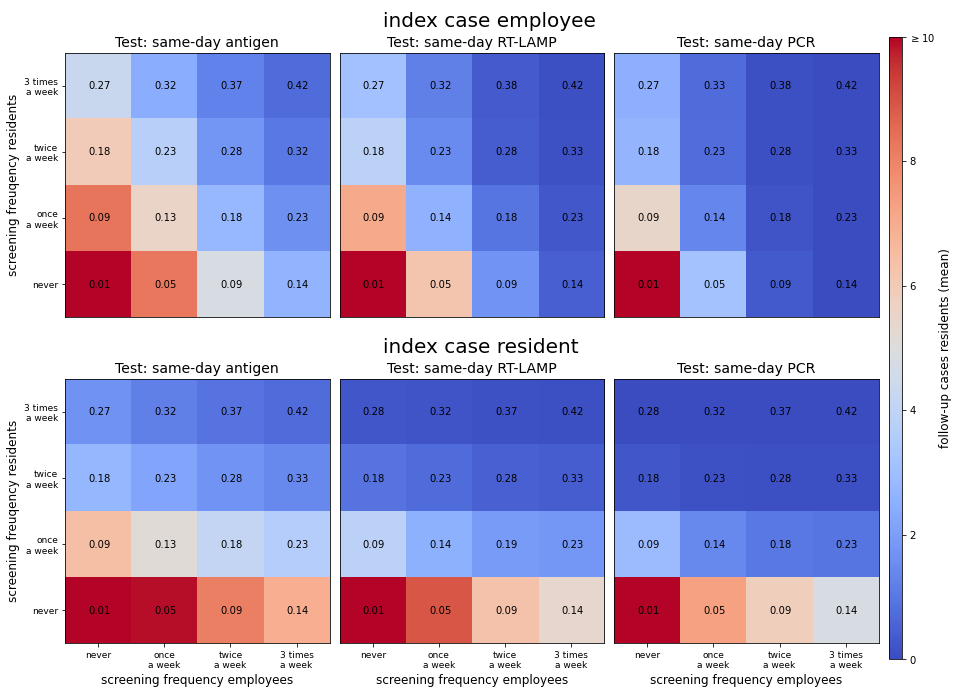

In [273]:
metric = 'infected_residents_mean'
sim_name = 'simulation_results'
screening_params = screening_intervals

# figure layout & axis setup
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(nrows=4, ncols=4, width_ratios=[1,1,1, 0.05],\
                       height_ratios=[0.1,1,0.1,1], wspace=0.05, hspace=0)

title_ax_1 = fig.add_subplot(gs[0, 0:])
hmap_ax_1 = fig.add_subplot(gs[1, 0])
hmap_ax_2 = fig.add_subplot(gs[1, 1])
hmap_ax_3 = fig.add_subplot(gs[1, 2])

title_ax_2 = fig.add_subplot(gs[2, 0:])
hmap_ax_4 = fig.add_subplot(gs[3, 0])
hmap_ax_5 = fig.add_subplot(gs[3, 1])
hmap_ax_6 = fig.add_subplot(gs[3, 2])

cbar_ax = fig.add_subplot(gs[1:, 3])

hmap_axes = [[hmap_ax_1, hmap_ax_2, hmap_ax_3], [hmap_ax_4, hmap_ax_5, hmap_ax_6]]
title_axes = [title_ax_1, title_ax_2]

# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin=0
vmax=10
vstep=2

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode in enumerate(['employee', 'resident']):
    df = data.loc[:,:,:, index_case_mode]
    
    # remove all axis labels and ticks for the heatmaps
    t_ax = title_axes[i]
    t_ax.set_xticks([])
    t_ax.set_yticks([])
    t_ax.set_frame_on(False)
    t_ax.set_xlim(0, 1)
    t_ax.set_ylim(0, 3)
    t_ax.text(0.38, 1, index_case_map[index_case_mode], fontsize=20)
        
    j = 0
    # compare same-day turnover testing for different testing technologies
    for j, ax, test_type in zip(range(3), hmap_axes[i],\
                       ['same_day_antigen', 'same_day_LAMP', 'same_day_PCR']):
        
        # set flag to set axis ticks only for heatmaps at the boundaries of 
        # the figure
        xticks = False
        yticks = False
        if i > 0:
            xticks = True
        if j in [0, 3]:
            yticks = True
            
        # put the testing technology in the heatmap title
        ax.set_title('Test: {}'\
                .format(test_name_map[test_type]), fontsize=14)
        
        # plot heatmap of the scenario
        img = af.get_image(df, test_type, screening_params, metric)
        if index_case_mode == 'resident':
            # if a resident is the index case, we need to subtract 1 from the
            # number of infected residents, to calculate the "outbreak size",
            # which is defined as the number of FOLLOW-UP cases, given an index
            # case
            img = img - 1
        img_plot = af.plot_heatmap(ax, img, screening_params, vmin, vmax,
                                   xticks, yticks, xlabel, ylabel)
        
        # annotate heatmap with tests / days / agent
        test_rate = af.get_image(df, test_type, screening_params, 
                                    'test_rate_mean')
        af.annotate_heatmap(ax, test_rate)
        
# colorbar
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                        ticks=np.arange(vmin, vmax + 1, vstep))
yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)      

plt.savefig(join(dst_path,
            'screening_frequency_test_technology_UK_variang_{}.png'\
            .format(language[0:3])), dpi=300, transparent=True)
plt.savefig(join(dst_path, 
            'screening_frequency_test_technology_UK_variant_{}.pdf'\
            .format(language[0:3])), transparent=True)

### PCR: different turnover times

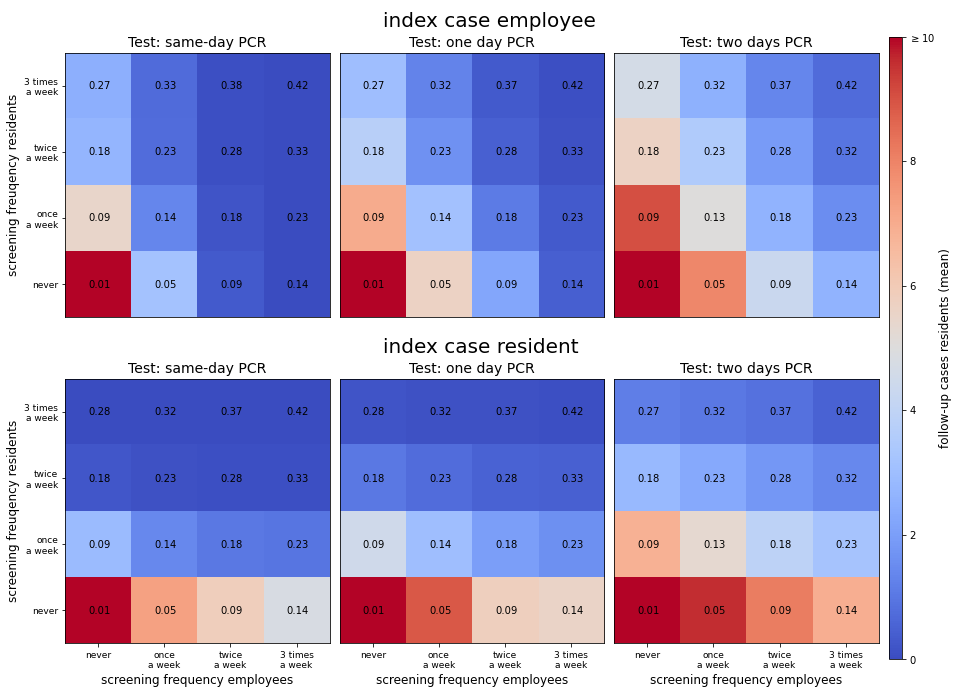

In [275]:
metric = 'infected_residents_mean'
sim_name = 'simulation_results'
screening_params = screening_intervals

# figure layout & axis setup
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(nrows=4, ncols=4, width_ratios=[1,1,1, 0.05],\
                       height_ratios=[0.1,1,0.1,1], wspace=0.05, hspace=0)

title_ax_1 = fig.add_subplot(gs[0, 0:])
hmap_ax_1 = fig.add_subplot(gs[1, 0])
hmap_ax_2 = fig.add_subplot(gs[1, 1])
hmap_ax_3 = fig.add_subplot(gs[1, 2])

title_ax_2 = fig.add_subplot(gs[2, 0:])
hmap_ax_4 = fig.add_subplot(gs[3, 0])
hmap_ax_5 = fig.add_subplot(gs[3, 1])
hmap_ax_6 = fig.add_subplot(gs[3, 2])

cbar_ax = fig.add_subplot(gs[1:, 3])

hmap_axes = [[hmap_ax_1, hmap_ax_2, hmap_ax_3], [hmap_ax_4, hmap_ax_5, hmap_ax_6]]
title_axes = [title_ax_1, title_ax_2]

# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 10
vstep = 2

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode in enumerate(['employee', 'resident']):
    df = data.loc[:,:,:, index_case_mode]
    
    # set flag to set axis ticks only for heatmaps at the boundaries of 
    # the figure
    t_ax = title_axes[i]
    t_ax.set_xticks([])
    t_ax.set_yticks([])
    t_ax.set_frame_on(False)
    t_ax.set_xlim(0, 1)
    t_ax.set_ylim(0, 3)
    t_ax.text(0.38, 1, index_case_map[index_case_mode], fontsize=20)
    
    # compare different test result turnover times for PCR tests
    for j, ax, test_type in zip(range(3), hmap_axes[i], \
                        ['same_day_PCR', 'one_day_PCR', 'two_day_PCR']):
        xticks = False
        yticks = False
        if i > 0:
            xticks = True
        if j in [0, 3]:
            yticks = True
            
        # put the turnover time in the heatmap title
        ax.set_title('Test: {}'\
                .format(test_name_map[test_type]), fontsize=14)
        
        # plot heatmap of the scenario
        img = af.get_image(df, test_type, screening_params, metric)
        if index_case_mode == 'resident':
            img = img - 1
        img_plot = af.plot_heatmap(ax, img, screening_params, vmin, vmax,
                                   xticks, yticks, xlabel, ylabel)
        
        # annotate heatmap with tests / days / agent
        test_rate = af.get_image(df, test_type, screening_params, 
                                    'test_rate_mean')
        af.annotate_heatmap(ax, test_rate)

# colorbar
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                ticks=np.arange(vmin, vmax+1, vstep))
yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)      

plt.savefig(join(dst_path, 
            'screening_frequency_PCR_turnover_time_UK_variant_{}.png'\
            .format(language[0:3])), dpi=300, transparent=True)
plt.savefig(join(dst_path,
            'screening_frequency_PCR_turnover_time_{}.pdf'\
            .format(language[0:3])))

### Number of agents infected by the index case

In [276]:
# all ensembles that had no preventive testing in place (the test technology
# does not make a difference, because it is only used for potential preventive
# tests anyways)
no_measures = data.loc[:,'never', 'never'].copy().reset_index()
nm_residents = no_measures[no_measures['index_case'] == 'resident']
nm_employees = no_measures[no_measures['index_case'] == 'employee']

In [277]:
print('index case resident: R = {:1.4f} +- {:1.4f}'\
      .format(nm_residents['R0_mean'].mean(), nm_residents['R0_std'].mean()))
print('index case employee: R = {:1.4f} +- {:1.4f}'\
      .format(nm_employees['R0_mean'].mean(), nm_employees['R0_std'].mean()))

index case resident: R = 1.9920 +- 1.9858
index case employee: R = 1.8664 +- 1.8716


### Outbreak sizes

**Note**: for resident index cases, the index case needs to be subtracted from the outbreak size

#### Only TTI

In [278]:
nm_residents['infected_residents_mean'] - 1

1    11.313
3    11.842
5    12.236
7    12.056
9    11.567
Name: infected_residents_mean, dtype: float64

In [279]:
nm_residents['infected_residents_std'] - 1

1    10.479757
3    10.457238
5    10.409491
7    10.393273
9    10.482132
Name: infected_residents_std, dtype: float64

In [280]:
nm_employees['infected_residents_mean']

0    12.547
2    11.805
4    12.400
6    12.823
8    12.411
Name: infected_residents_mean, dtype: float64

In [281]:
nm_employees['infected_residents_std']

0    11.938187
2    11.820182
4    11.724823
6    11.724467
8    11.894434
Name: infected_residents_std, dtype: float64

#### Minimum and maximum

In [282]:
data['infected_residents_mean'].idxmin()

('same_day_PCR', '3 times\na week', '3 times\na week', 'employee')

In [283]:
data.loc[data['infected_residents_mean'].idxmin()]['infected_residents_mean']

0.0

In [284]:
data.loc[data['infected_residents_mean'].idxmin()]['infected_residents_std']

0.0

#### Realistic scenario I: employees screened 2x / week

##### Same-day Antigen

In [285]:
# employee index case
mean = data.loc['same_day_antigen', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_antigen', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

4.795 +- 8.205260587044224


In [286]:
# resident index case
mean = data.loc['same_day_antigen', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

8.095 +- 8.98647493357277


##### Same-day LAMP

In [287]:
# employee index case
mean = data.loc['same_day_LAMP', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_LAMP', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.738 +- 4.7841659925471065


In [288]:
# resident index case
mean = data.loc['same_day_LAMP', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_LAMP', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

6.307 +- 7.777611602686408


##### One-day PCR

In [289]:
# employee index case
mean = data.loc['one_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['one_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.23 +- 5.706984288542388


In [290]:
# resident index case
mean = data.loc['one_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['one_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.819 +- 7.497496345544388


##### Same-day PCR

In [291]:
# employee index case
mean = data.loc['same_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.333 +- 2.0582388946250503


In [292]:
# resident index case
mean = data.loc['same_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.836 +- 7.172904192484001


##### Two-day PCR

In [293]:
# employee index case
mean = data.loc['two_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

4.315 +- 7.885299801082578


In [294]:
# resident index case
mean = data.loc['two_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

8.142 +- 8.988360619524933


#### Realistic scenario II: employees screened 1x / week

##### Same-day PCR

In [295]:
# employee index case
mean = data.loc['same_day_PCR', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.202 +- 6.706875440783001


In [296]:
# resident index case
mean = data.loc['same_day_PCR', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

7.289 +- 8.621125379137156


##### Same-day LAMP

In [297]:
# employee index case
mean = data.loc['same_day_LAMP', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_LAMP', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

6.201 +- 8.908757767779129


In [298]:
# resident index case
mean = data.loc['same_day_LAMP', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_LAMP', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

8.927 +- 9.565310562975265


##### Same-day Antigen

In [299]:
# employee index case
mean = data.loc['same_day_antigen', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_antigen', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

8.244 +- 10.343764182223872


In [300]:
# resident index case
mean = data.loc['same_day_antigen', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

9.919 +- 10.307797518853857


#### Two-day PCR

##### Employees 3x / week, residents never 

In [301]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.639 +- 6.024697168819025


In [302]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

6.931 +- 8.239789629179445


##### Employees 3x / week, residents 1x / week 

In [303]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.557 +- 3.8750182924428582


In [304]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.2060000000000004 +- 4.960258881164185


##### Employees 3x / week, residents 2x / week 

In [305]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.964 +- 2.364803648571334


In [306]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.44 +- 2.757172827735324


##### Employees 3x / week, residents 3x / week 

In [307]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.713 +- 1.526748820848394


In [308]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.5409999999999999 +- 1.1847880497045549


#### Same-day PCR

In [309]:
# employee index case
mean = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.405 +- 2.842719834253115


In [310]:
# resident index case
mean = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.4089999999999998 +- 2.89795050287563


### Test rates

#### Diagnostic testing base rate

In [311]:
data.loc[:, 'never', 'never', :]['test_rate_mean'].mean()

0.00681938628093241

In [312]:
data.loc[:, 'never', 'never', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.005255
                  resident      0.005198
same_day_LAMP     employee      0.005291
                  resident      0.005304
same_day_PCR      employee      0.005204
                  resident      0.005204
one_day_PCR       employee      0.005188
                  resident      0.005161
two_day_PCR       employee      0.005182
                  resident      0.005237
Name: test_rate_std, dtype: float64

#### Test rates employeed screened 2x / week

In [313]:
data.loc[:, 'twice\na week', 'never', :]['test_rate_mean']

test_type         index_case
same_day_antigen  employee      0.091785
                  resident      0.091811
same_day_LAMP     employee      0.093727
                  resident      0.093460
same_day_PCR      employee      0.093513
                  resident      0.093234
one_day_PCR       employee      0.092439
                  resident      0.093020
two_day_PCR       employee      0.090705
                  resident      0.090934
Name: test_rate_mean, dtype: float64

In [314]:
data.loc[:, 'twice\na week', 'never', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.011581
                  resident      0.011049
same_day_LAMP     employee      0.011693
                  resident      0.010289
same_day_PCR      employee      0.012592
                  resident      0.009873
one_day_PCR       employee      0.012545
                  resident      0.010771
two_day_PCR       employee      0.012624
                  resident      0.011980
Name: test_rate_std, dtype: float64

#### Test rates residents screened 2x / week

In [315]:
data.loc[:, 'never', 'twice\na week', :]['test_rate_mean']

test_type         index_case
same_day_antigen  employee      0.177670
                  resident      0.180796
same_day_LAMP     employee      0.182090
                  resident      0.182438
same_day_PCR      employee      0.182958
                  resident      0.184510
one_day_PCR       employee      0.181408
                  resident      0.183426
two_day_PCR       employee      0.177381
                  resident      0.178655
Name: test_rate_mean, dtype: float64

In [316]:
data.loc[:, 'never', 'twice\na week', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.019689
                  resident      0.021660
same_day_LAMP     employee      0.018907
                  resident      0.022495
same_day_PCR      employee      0.018012
                  resident      0.023159
one_day_PCR       employee      0.019337
                  resident      0.022082
two_day_PCR       employee      0.021412
                  resident      0.023177
Name: test_rate_std, dtype: float64

#### Test rates residents screened 3x / week

In [317]:
data.loc[:, 'never', '3 times\na week', :]['test_rate_mean']

test_type         index_case
same_day_antigen  employee      0.271648
                  resident      0.274960
same_day_LAMP     employee      0.273525
                  resident      0.278739
same_day_PCR      employee      0.274196
                  resident      0.277561
one_day_PCR       employee      0.272739
                  resident      0.277940
two_day_PCR       employee      0.267498
                  resident      0.274642
Name: test_rate_mean, dtype: float64

In [318]:
data.loc[:, 'never', '3 times\na week', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.022156
                  resident      0.023649
same_day_LAMP     employee      0.020896
                  resident      0.022865
same_day_PCR      employee      0.018087
                  resident      0.024085
one_day_PCR       employee      0.020734
                  resident      0.021940
two_day_PCR       employee      0.025442
                  resident      0.023489
Name: test_rate_std, dtype: float64

### Results table

In [319]:
table_data = data.loc[:,:,:,'employee']

In [320]:
table_cols = ['infected_residents_mean', 'infected_residents_std',
              'infected_residents_median', 'infected_residents_0.10',
              'infected_residents_0.90', 'R0_mean', 'R0_std', 'test_rate_mean', 'test_rate_std']
table_data = table_data.loc[:, :, ['never', 'once\na week']][table_cols]\
    .sort_values(by=['test_type', 'employee_screen_interval', 'resident_screen_interval'])
table_data.to_csv(join(res_path, 'table_testing_strategy_UK_variant.csv'))

### Preventive testing rates

In [321]:
data.loc[:,'3 times\na week', 'never', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.139183       0.012900
                 resident          0.137113       0.014048
same_day_LAMP    employee          0.140958       0.011863
                 resident          0.138468       0.013405
same_day_PCR     employee          0.141106       0.012381
                 resident          0.139139       0.012817
one_day_PCR      employee          0.140078       0.011841
                 resident          0.138149       0.014023
two_day_PCR      employee          0.137532       0.014461
                 resident          0.135887       0.015895

In [322]:
data.loc[:,'never', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.271648       0.022156
                 resident          0.274960       0.023649
same_day_LAMP    employee          0.273525       0.020896
                 resident          0.278739       0.022865
same_day_PCR     employee          0.274196       0.018087
                 resident          0.277561       0.024085
one_day_PCR      employee          0.272739       0.020734
                 resident          0.277940       0.021940
two_day_PCR      employee          0.267498       0.025442
                 resident          0.274642       0.023489

In [323]:
data.loc[:,'3 times\na week', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.418748       0.031099
                 resident          0.421391       0.032299
same_day_LAMP    employee          0.422980       0.034473
                 resident          0.422304       0.035686
same_day_PCR     employee          0.422649       0.036234
                 resident          0.422929       0.035606
one_day_PCR      employee          0.421072       0.034888
                 resident          0.423439       0.036183
two_day_PCR      employee          0.419228       0.033087
                 resident          0.420092       0.032418